* json how to: https://realpython.com/python-requests/
* USA source: https://covidtracking.com/us-daily/
* world source: https://www.trackcorona.live
* state pop source: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_1873399417
* state abbreviation source: https://www.50states.com/abbreviations.htm
* county population source: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html

https://www.colors.lol/

# State

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [3]:
state_response = requests.get('https://covidtracking.com/api/states')

if state_response.status_code == 200:
    print('Success!')
else:
    print('An error has occurred')
    exit()


Success!


In [4]:
# Convert json to df
df_state = pd.json_normalize(state_response.json())

In [5]:
# Import states, abbreviations, state population
abbrevs = pd.read_csv('abbrevs.csv')
statepop = pd.read_csv('statepop.csv').iloc[5:].loc[:,('NAME','POPESTIMATE2019')].reset_index(drop = True)
state_pop = abbrevs.merge(statepop, left_on='State', right_on='NAME').loc[:,('NAME','Abbreviation','POPESTIMATE2019')]
state_pop.columns = ['state','abbrev','Pop2019']

In [6]:
class state_tracker:
    '''
    Returns covid stats, sorts by preference, and plots results
    '''
    def __init__(self, df, state_pop=state_pop, states_list=['MA', 'TX', 'OH', 'VT']):
        '''
        Selects appropriate columns and filters by state. Calculates percent deaths and percent hospitalized.
        
        % Deaths = Deaths/Positive
        % Hospitalized = Hospitalized/Positive
        '''
        # Select appropriate columns
        self.df = df[['state','positive','negative','hospitalized','death','lastUpdateEt']]
        # Rename columns
        self.df.columns = ['State', 'Positive', 'Negative', 'Hospitalized', 'Deaths', 'Last Updated']
        self.all_us = self.df.sum()['Positive']
        # Replace NaN with 0
        self.df = self.df.fillna(0)
        
        self.state_pop = state_pop
        self.merged = self.df.merge(self.state_pop, left_on='State', right_on='abbrev')
        self.merged = self.merged.drop(['state','abbrev'], 1)
        
        df_select = self.merged
        # Percent death calculation
        df_select['Total Tested'] = df_select['Positive'] + df_select['Negative']
        df_select['% Pos of Tested'] = round((df_select['Positive']/df_select['Total Tested']) *100,2)
        df_select['% Deaths'] = round((df_select['Deaths']/df_select['Positive']) *100,2)
        df_select['% Hospitalized'] = round((df_select['Hospitalized']/df_select['Positive']) *100,2)
        df_select['% Pop Positive'] = round((df_select['Positive']/df_select['Pop2019']) *100,2)
        df_select['% of US infected'] = round((df_select['Positive']/self.all_us) *100,2)
        # Select the states
        self.jnd = '|'.join(states_list)
        df_select = self.merged[self.merged['State'].str.contains(self.jnd)]
               
        self.df_select = pd.DataFrame(df_select)
    def all_df(self):
        '''
        Returns all states, select columns only.
        '''
        return self.merged
    
    def plotter(self, sort_by="% Hospitalized"):
        '''
        Plots the formatted df by the sort_by variable.
        '''
        df = self.df_select.sort_values(sort_by, ascending=False)
        sns.barplot(x = df.State, y = df[sort_by])
        if sort_by=="% Pop Positive":
            plt.title(f"{sort_by} per State")
            plt.ylim(0,1)
        else:
            plt.title(f"Number of {sort_by} results per State")
        
        return plt.show()
    
    def table(self, sort_by="% Hospitalized"):
        '''
        Returns the formatted df, but in a readable and prettified table
        
        Adds commas at 1000 values
        Adds % to the percent tables
        All values are in string
        '''
        df_select = self.df_select
        df_select = df_select.sort_values(sort_by, ascending = False)

        # Prettify output
        # Format percentages
        df_select['% Deaths'] = df_select['% Deaths'].apply(str) + "%"
        df_select['% Hospitalized'] = df_select['% Hospitalized'].apply(str) + "%"
        df_select['% Pop Positive'] = df_select['% Pop Positive'].apply(str) + "%"
        df_select['% of US infected'] = df_select['% of US infected'].apply(str) + "%"
        df_select['% Pos of Tested'] = df_select['% Pos of Tested'].apply(str) + "%"

        # Round floats to just integers, use commas to separate
        columns = ['Positive', 'Negative', 'Hospitalized', 'Deaths', 'Pop2019']

        for col in columns:
            df_select[col] = pd.to_numeric(df_select[col]).apply(round)
            df_select[col] = df_select[col].apply(lambda x: "{:,}".format(x))
        self.table = df_select
        return(self.table)


In [7]:
yan = ['MA', 'TX', 'OH', 'VT', 'NY', 'NJ', 'CA']
chat = ['MA', 'TX', 'OH', 'VT']

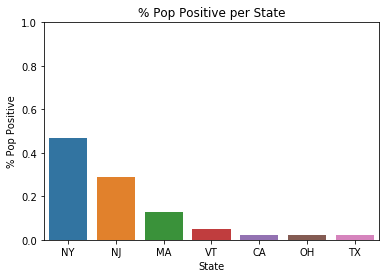

In [8]:
covid = state_tracker(df_state, states_list=yan)
covid.plotter(sort_by="% Pop Positive")


In [9]:
covid.table(sort_by = "Total Tested")

,State,Positive,Negative,Hospitalized,Deaths,Last Updated,Pop2019,Total Tested,% Pos of Tested,% Deaths,% Hospitalized,% Pop Positive,% of US infected
33,NY,"92,381","146,584","20,817","2,373",4/02 11:45,"19,453,561",238965,38.66%,2.57%,22.53%,0.47%,38.14%
30,NJ,"25,590","33,520",0,537,4/02 13:00,"8,882,190",59110,43.29%,2.1%,0.0%,0.29%,10.57%
18,MA,"8,966","47,642",813,154,4/02 16:00,"6,892,503",56608,15.84%,1.72%,9.07%,0.13%,3.7%
42,TX,"4,669","46,010",196,70,4/02 13:00,"28,995,881",50679,9.21%,1.5%,4.2%,0.02%,1.93%
34,OH,"2,902","32,016",802,81,4/02 14:00,"11,689,100",34918,8.31%,2.79%,27.64%,0.02%,1.2%
4,CA,"9,191","23,809",0,203,4/01 00:00,"39,512,223",33000,27.85%,2.21%,0.0%,0.02%,3.79%
45,VT,338,"4,373",45,17,4/02 13:00,"623,989",4711,7.17%,5.03%,13.31%,0.05%,0.14%


In [10]:
all_df = covid.all_df()
all_pos = all_df.sum()["Positive"]
all_dead = all_df.sum()["Deaths"]
all_hosp = all_df.sum()["Hospitalized"]

print("Totals in the USA to date:")
print(f'     Infected: {"{:,}".format(round(all_pos))}')
print(f'     Hospitalized: {"{:,}".format(round(all_hosp))}') 
print(f'     Deaths: {"{:,}".format(round(all_dead))}')

Totals in the USA to date:
     Infected: 240,946
     Hospitalized: 33,028
     Deaths: 5,839


# World

In [11]:
import time

In [12]:
world_response = requests.get('https://www.trackcorona.live/api/countries/')

if world_response.status_code == 200:
    print('Success!')
else:
    print('An error has occurred')
    exit()

Success!


In [13]:
# Convert json to df
df_world = pd.json_normalize(world_response.json()['data'])

In [14]:
world_pop_df = pd.read_csv("countries of the world.csv")

In [15]:
world_pop = world_pop_df.loc[:,("Country","Population")]

In [16]:
df_world = df_world.sort_values("location")

In [18]:
country_list = ['United States', 'Hungary', 'Jordan', 'Brazil', 
                'Cambodia', 'Germany','Mexico', 'China', 'Poland',
                'Italy', 'Spain','France','United Kingdom', 'Russia'
               ]

In [20]:
def world_tracker(df, country_list=country_list, sort_by="Confirmed"):
    df = df.loc[:, ['location', 'confirmed','dead','recovered','updated']]
    df.columns = ["Location","Confirmed", "Dead", "Recovered", "Updated"]
    df["% of US"]=round((df["Confirmed"]/df.loc[df["Location"]=="United States", "Confirmed"].values[0]) * 100,2)
    df["% Share of World's Confirmed"] = round(df['Confirmed']/sum(df['Confirmed'])*100,2)
    df["% Share of World's Recovered"] = round(df['Recovered']/sum(df['Recovered'])*100,2)
    
    jnd = '|'.join(country_list)
    df = df[df['Location'].str.contains(jnd)]    
    df = df.sort_values(sort_by, ascending=False)
    
    return df

In [21]:
world = world_tracker(df_world, [""])

In [22]:
world_infected = sum(world['Confirmed'])
US_infected = world.loc[1]['Confirmed']
US_world_ratio = round((world.loc[1]['Confirmed']/world_infected) * 100, 2)

world_deaths = sum(world['Dead'])
US_deaths = world.loc[1]['Dead']
US_world_deaths = round((world.loc[1]['Dead']/world_deaths) * 100, 2)

world_recovered = sum(world['Recovered'])
US_recovered = world.loc[1]['Recovered']
US_world_recovered = round((world.loc[1]['Recovered']/world_recovered) * 100, 2)

print("Totals in the World to date:")
print(f"     World Confirmed: {world_infected:,}")
print(f"     US Confirmed: {US_infected:,}")
print(f"     {US_world_ratio:,}% of the world's confirmed are in the US.")
print("")
print(f"     World Deaths: {world_deaths:,}")
print(f"     US Deaths: {US_deaths:,}")
print(f"     {US_world_deaths:,}% of the world's deaths are in the US")
print("")
print(f"     World Recovered: {world_recovered:,}")
print(f"     US Recovered: {US_recovered:,}")
print(f"     {US_world_recovered:,}% of the world's recovered are in the US")

Totals in the World to date:
     World Confirmed: 1,043,801
     US Confirmed: 245,974
     23.57% of the world's confirmed are in the US.

     World Deaths: 54,430
     US Deaths: 6,126
     11.25% of the world's deaths are in the US

     World Recovered: 221,923
     US Recovered: 10,411
     4.69% of the world's recovered are in the US


In [28]:
world_tracker(df_world)

,Location,Confirmed,Dead,Recovered,Updated,% of US,% Share of World's Confirmed,% Share of World's Recovered
18,United States,245175,6059,10403,2020-04-03 13:40:05.071644+00:00,100.00,23.57,4.74
19,Spain,117710,10935,30513,2020-04-03 13:40:05.178794+00:00,48.01,11.32,13.89
20,Italy,115242,13915,18278,2020-04-03 13:40:05.271672+00:00,47.00,11.08,8.32
117,Germany,86667,1129,22440,2020-04-03 13:40:23.697457+00:00,35.35,8.33,10.21
134,China,81620,3322,76571,2020-04-03 13:40:05.385507+00:00,33.29,7.85,34.85
122,France,59105,4503,12427,2020-04-03 13:42:22.915852+00:00,24.11,5.68,5.66
120,Brazil,8076,329,127,2020-04-03 13:40:25.005802+00:00,3.29,0.78,0.06
42,Russia,4149,34,281,2020-04-03 13:40:09.176387+00:00,1.69,0.40,0.13
46,Poland,3149,59,56,2020-04-03 13:40:09.857257+00:00,1.28,0.30,0.03
177,Mexico,1510,50,633,2020-04-03 13:40:26.485266+00:00,0.62,0.15,0.29


# Counties and Cities

## Import from Sources

In [23]:
city_response = requests.get('https://www.trackcorona.live/api/cities/')

if city_response.status_code == 200:
    print('Success!')
else:
    print('An error has occurred')
    exit()

Success!


In [24]:
# Convert json to df
df_citycounty = pd.json_normalize(city_response.json()['data'])

## Town Tracker

In [25]:
town_list = ['Corse','Heerlen']

In [26]:
def town_tracker (df, town_list=town_list, sort_by="confirmed"):
    df_city = df[~df['location'].str.contains(" County")]
    jnd = '|'.join(town_list)
    df_find = df_city[df_city['location'].str.contains(jnd)]
    df_find = df_find.sort_values(sort_by, ascending=False)
    return df_find

In [27]:
town_tracker(df_citycounty)

,location,latitude,longitude,confirmed,dead,recovered,updated
2446,Corse,42.039604,9.012893,250,23.0,110.0,2020-04-03 15:02:32.899336+00:00
35,Heerlen,50.888174,5.979499,72,NaN,NaN,2020-04-03 15:02:06.692302+00:00


## County Tracker

In [28]:
county_list = ['Summit County, Ohio', 
                'Cuyahoga County, Ohio', 
                'Suffolk County, Massachusetts',
                'Walker County, Texas',
                'Brooklyn', 'Queens', 'Manhattan', 'Bronx', 'Staten'] 

In [29]:
county_pop = pd.read_excel("countypop.xlsx", sheet_name=1)
county_pop = county_pop.iloc[1:].reset_index(drop=True)
county_pop['County'] = county_pop['County'].str[1:] # remove period from beginning of each county name

In [30]:
def county_tracker(df, county_pop = county_pop, county_list=county_list, sort_by="confirmed"):
    df_county = df[df['location'].str.contains(" County")].reset_index(drop=True)
    df_pop = df_county.merge(county_pop, left_on="location", right_on="County").drop("County", axis=1)
    df_pop['% confirmed'] = round((df_pop['confirmed']/df_pop['Population'])*100, 2)   
    
    df_pop = df_pop.sort_values(sort_by, ascending=False)

    columns = ['confirmed','Population']       
    for col in columns:
        df_pop[col] = pd.to_numeric(df_pop[col]).apply(round)
        df_pop[col] = df_pop[col].apply(lambda x: "{:,}".format(x))

    df_pop['% confirmed'] = df_pop['% confirmed'].apply(str) + "%"
    
    jnd = '|'.join(county_list)
    df_find = df_pop[df_pop['location'].str.contains(jnd)]
    return df_find


In [31]:
county_tracker(df_citycounty)

,location,latitude,longitude,confirmed,dead,recovered,updated,Population,% confirmed
206,"Queens County, New York",40.728224,-73.794852,"16,819",0.0,NaN,2020-04-03 15:00:49.056594+00:00,"2,253,858",0.75%
231,"Bronx County, New York",40.837049,-73.865430,"9,343",0.0,NaN,2020-04-03 15:00:49.042380+00:00,"1,418,207",0.66%
2149,"Suffolk County, Massachusetts",42.352287,-71.050423,"1,896",19.0,0.0,2020-04-02 15:01:04.033279+00:00,"803,907",0.24%
1742,"Cuyahoga County, Ohio",41.433923,-81.675820,663,12.0,0.0,2020-04-02 15:01:04.033279+00:00,"1,235,072",0.05%
1748,"Summit County, Ohio",41.091899,-81.559643,155,7.0,0.0,2020-04-02 15:01:04.033279+00:00,"541,013",0.03%
1974,"Walker County, Texas",30.681539,-95.645795,7,0.0,0.0,2020-04-02 15:01:04.033279+00:00,"72,971",0.01%
